In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Luke's CD

import os, sys
%cd "/content/drive/MyDrive/CSCI181V - Final Project"

# add the current directory to the Python module search path
sys.path.append(os.getcwd())


In [ ]:
# Vikram's CD

import os, sys
%cd "/content/drive/MyDrive/Senior Year/Spring Semester/Reinforcement Learning/CSCI181V - Final Project"

# add the current directory to the Python module search path
sys.path.append(os.getcwd())


/content/drive/.shortcut-targets-by-id/1XD8rITyzVB-Y5GCzpzGaIV4b9nN_PN3m/CSCI181V - Final Project


In [ ]:
!pip install gymnasium torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
from gymnasium.envs.registration import register

register(
    id="Snake-10x10-v0",                 # ASCII hyphens
    entry_point="Snake:SnakeEnv",        # file Snake.py (module) : class
    max_episode_steps=400,
)



In [ ]:
env = gym.make("Snake-10x10-v0")

In [ ]:
import random
import numpy as np
from collections import deque
from typing import Deque, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F

device = (torch.device("cpu")
)
print(f"Using {device} device")

Using cpu device


In [ ]:
# Initializing PPO Networks

class OneHotObsWrapper(gym.ObservationWrapper):
    """Convert 10 × 10 int grid → (4, 10, 10) one‑hot float tensor."""

    def __init__(self, env: gym.Env):
        super().__init__(env)
        h, w = env.observation_space.shape
        self.observation_space = gym.spaces.Box(0.0, 1.0, shape=(4, h, w), dtype=np.float32)

    def observation(self, obs):
        one_hot = np.zeros((4, *obs.shape), dtype=np.float32)
        for v in range(4):
            one_hot[v][obs == v] = 1.0
        return one_hot


class PolicyNetwork(nn.Module):
  def __init__(self, num_actions = 4):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(4, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Flatten(),  # shape: (B, 64*10*10)
        nn.Linear(64 * 10 * 10, 256),
        nn.ReLU(),
        nn.Linear(256, num_actions),
        nn.Softmax(dim=-1)
    )

  def forward(self, x):
    return self.net(x)  # shape: (batch_size, 4)

class ValueNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(4, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * 10 * 10, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )

  def forward(self, x):
      return self.net(x).squeeze(-1)  # shape: (batch_size,)

pi = PolicyNetwork().to(device)
V  = ValueNetwork().to(device)

pi_optimizer = torch.optim.Adam(pi.parameters(), lr=3e-4)
V_optimizer  = torch.optim.Adam(V.parameters(), lr=1e-3)

pi_old = PolicyNetwork().to(device)
pi_old.load_state_dict(pi.state_dict())

<All keys matched successfully>

In [ ]:
env = OneHotObsWrapper(env)

In [ ]:
# --- Hyperparameters ---
gamma = 0.99
lam = 0.95
num_updates = 2000
entropy_coef = 0.05
n_epochs = 5
mini_batch_size = 32
T = 128
clip_eps = 0.2

# --- Logs ---
reward_log = []
log_interval = 10

# --- Reset env ---
obs, _ = env.reset()
obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)  # (1, 4, 10, 10)

for update in range(num_updates):
    states = []
    actions = []
    log_probs_old = []
    values = []
    rewards = []
    dones = []

    # --- Collect rollout of T steps ---
    for _ in range(T):
        with torch.no_grad():
            probs = pi(obs)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            value = V(obs)

        next_obs, reward, done, truncated, _ = env.step(action.item())
        next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device).unsqueeze(0)

        states.append(obs)
        actions.append(action)
        log_probs_old.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float32, device=device))
        dones.append(torch.tensor([done], dtype=torch.float32, device=device))

        obs = next_obs

        if done or truncated:
            obs, _ = env.reset()
            obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

    # --- Bootstrap final value ---
    with torch.no_grad():
        values.append(V(obs))

    # --- Convert to tensors ---
    states = torch.cat(states)
    actions = torch.stack(actions).squeeze()
    log_probs_old = torch.stack(log_probs_old).squeeze()
    rewards = torch.stack(rewards).squeeze()
    dones = torch.stack(dones).squeeze()
    values = torch.cat(values).squeeze()

    # --- GAE advantage estimation ---
    deltas = rewards + gamma * values[1:] * (1 - dones) - values[:-1]
    advantages = torch.zeros_like(deltas)
    gae = 0
    for t in reversed(range(T)):
        gae = deltas[t] + gamma * lam * (1 - dones[t]) * gae
        advantages[t] = gae

    targets = advantages + values[:-1]

    # --- Flatten everything ---
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # --- PPO update loop ---
    for _ in range(n_epochs):
        indices = torch.randperm(T)
        for start in range(0, T, mini_batch_size):
            end = start + mini_batch_size
            batch_idx = indices[start:end]

            s_batch = states[batch_idx]
            a_batch = actions[batch_idx]
            logp_old_batch = log_probs_old[batch_idx]
            V_targets = targets[batch_idx]
            adv_batch = advantages[batch_idx]

            probs = pi(s_batch)
            dist = Categorical(probs)
            logp = dist.log_prob(a_batch)
            entropy = dist.entropy().mean()

            ratio = torch.exp(logp - logp_old_batch)
            surr1 = ratio * adv_batch
            surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * adv_batch
            pi_loss = -torch.min(surr1, surr2).mean()
            pi_loss -= entropy_coef * entropy

            v_preds = V(s_batch).squeeze()
            v_loss = F.mse_loss(v_preds, V_targets)

            pi_optimizer.zero_grad()
            pi_loss.backward()
            pi_optimizer.step()

            V_optimizer.zero_grad()
            v_loss.backward()
            V_optimizer.step()

    # --- Reward logging ---
    ep_reward = rewards.sum().item()
    reward_log.append(ep_reward)

    if (update + 1) % log_interval == 0:
        avg_reward = np.mean(reward_log[-log_interval:])
        print(f"Update {update+1}/{num_updates} | Avg Reward: {avg_reward:.2f}")

Update 10/2000 | Avg Reward: -33.81
Update 20/2000 | Avg Reward: -31.74
Update 30/2000 | Avg Reward: -17.62
Update 40/2000 | Avg Reward: -23.89
Update 50/2000 | Avg Reward: -15.08
Update 60/2000 | Avg Reward: -17.88
Update 70/2000 | Avg Reward: -14.20
Update 80/2000 | Avg Reward: -15.58
Update 90/2000 | Avg Reward: -11.09
Update 100/2000 | Avg Reward: -13.27
Update 110/2000 | Avg Reward: -10.44
Update 120/2000 | Avg Reward: -6.35
Update 130/2000 | Avg Reward: -2.26
Update 140/2000 | Avg Reward: -6.88
Update 150/2000 | Avg Reward: -4.42
Update 160/2000 | Avg Reward: -0.01
Update 170/2000 | Avg Reward: -9.84
Update 180/2000 | Avg Reward: -8.52
Update 190/2000 | Avg Reward: -2.73
Update 200/2000 | Avg Reward: -12.23
Update 210/2000 | Avg Reward: -4.33
Update 220/2000 | Avg Reward: -0.09
Update 230/2000 | Avg Reward: -4.15
Update 240/2000 | Avg Reward: -2.94
Update 250/2000 | Avg Reward: -6.53
Update 260/2000 | Avg Reward: 2.29
Update 270/2000 | Avg Reward: 3.97
Update 280/2000 | Avg Rewar

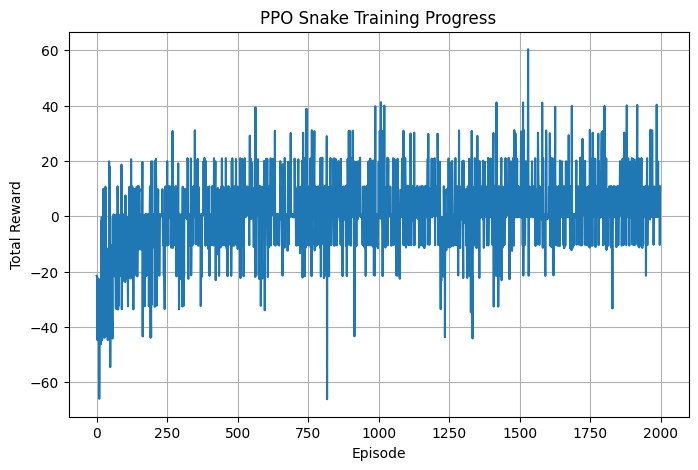

In [ ]:

# Plots Rewards

import matplotlib.pyplot as plt
# --- Plot rewards ---
plt.figure(figsize=(8,5))
plt.plot(reward_log)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Snake Training Progress')
plt.grid(True)
plt.show()

In [ ]:
import torch
import time
from IPython.display import clear_output

# --- Greedy Episode Visualization using PPO policy ---
env = OneHotObsWrapper(gym.make("Snake-10x10-v0"))
state, _ = env.reset()
done = False
truncated = False
total_reward = 0

while not done and not truncated:
    clear_output(wait=True)
    env.render()
    time.sleep(0.3)

    # Greedy action from PPO policy
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 4, 10, 10)
        action_probs = pi(state_tensor)  # Output shape: (1, 4)
        action = torch.argmax(action_probs, dim=1).item()

    state, reward, done, truncated, _ = env.step(action)
    total_reward += reward

# Final frame
clear_output(wait=True)
env.render()
print(f"\nTotal reward from greedy episode: {total_reward}")
env.close()

......𓆗==.
........=.
..........
..........
..........
..........
..........
..........
.........F
..........


Total reward from greedy episode: 22.240000000000293
